In [1]:
from model import Denoising_UNet
from utils import *
from data import mask_dataset
from tqdm import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
from glob import glob
import torch.nn as nn
import torch

sampleRate = 68.27

## Train - Val - Test sets

In [2]:
train_path = "train"
val_path = "validation"
test_path = "test"
train_files = glob(os.path.join(train_path, '*.npy'))
val_files = glob(os.path.join(val_path, '*.npy'))
test_files = glob(os.path.join(test_path, '*.npy'))

In [3]:
for file in train_files:
    if file in val_files:
        print(f"{file} in validation dataset.")
    elif file in test_files:
        print(f"{file} in test set.")
    else:
        pass

## Hyperparameters

In [4]:
N_sub = 32
batch_size = 56
hidden_layers = 4
learning_rate = 1e-6
num_epochs = 20

## Datasets and DataLoaders

In [5]:
train_dataset = mask_dataset(data_path='train', f_min=1, f_max=10, N_sub=N_sub, sampleRate=sampleRate)
train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, shuffle=True)

In [6]:
val_dataset = mask_dataset(data_path='validation', f_min=1, f_max=10, N_sub=N_sub, sampleRate=sampleRate)
val_loader = DataLoader(val_dataset, batch_size=batch_size, drop_last=True, shuffle=True)

In [7]:
# test_dataset = mask_dataset(data_path='test', f_min = 1, f_max = 10, N_sub=N_sub, sampleRate=sampleRate)
# test_loader = DataLoader(test_dataset,batch_size = batch_size,drop_last=True,shuffle = True)

In [8]:
# GPU
print(torch.cuda.get_device_name(0))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device is {device}.')

model = Denoising_UNet(input_bands=1, output_classes=1, hidden_channels=hidden_layers)
model.to(device)

# Mean Square Error 
criterion = nn.MSELoss()

# Optimizer:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

NVIDIA GeForce RTX 2070
device is cuda:0.


## Training

In [9]:
epochs_losses_train = []
epochs_losses_val = []
for epoch in range(num_epochs):
    print(f"Starting epoch: #{epoch}")
    batch_losses = []
    ## TRAIN ##
    for eval_samples, mask in tqdm(train_loader):
        # apply mask
        sample = eval_samples * mask.clone().detach()
        sample = torch.unsqueeze(sample.squeeze(), 1)

        # transfer to GPU
        eval_samples = eval_samples.to(device)
        sample = sample.to(device)
        optimizer.zero_grad()

        output = model(sample)
        loss = criterion(eval_samples.squeeze(), output.squeeze())
        batch_losses.append(loss.item())
        loss.backward()
        optimizer.step()
    epochs_losses_train.append(np.mean(batch_losses))
    model.eval()
    eval_losses = []
    with torch.no_grad():
        for eval_samples, mask in tqdm(val_loader):
            # apply mask
            sample = eval_samples * mask.clone().detach()
            sample = torch.unsqueeze(sample.squeeze(), 1)
            # transfer to GPU
            eval_samples = eval_samples.to(device)
            sample = sample.to(device)
            output = model(sample)
            loss = criterion(eval_samples.squeeze(), sample.squeeze())
            eval_losses.append(loss.item())
    epochs_losses_val.append(np.mean(eval_losses))
    model.train()

Starting epoch: #0


100%|██████████| 85/85 [00:18<00:00,  4.60it/s]


Starting epoch: #1


100%|██████████| 85/85 [00:18<00:00,  4.54it/s]


Starting epoch: #2


100%|██████████| 85/85 [00:19<00:00,  4.38it/s]


Starting epoch: #3


100%|██████████| 85/85 [01:51<00:00,  1.32s/it]


Starting epoch: #4


100%|██████████| 85/85 [01:27<00:00,  1.02s/it]


Starting epoch: #5


100%|██████████| 85/85 [01:49<00:00,  1.29s/it]


Starting epoch: #6


100%|██████████| 85/85 [01:54<00:00,  1.35s/it]


Starting epoch: #7


100%|██████████| 85/85 [00:06<00:00, 13.90it/s]


Starting epoch: #8


100%|██████████| 85/85 [00:06<00:00, 13.84it/s]


Starting epoch: #9


100%|██████████| 85/85 [00:05<00:00, 14.18it/s]


Starting epoch: #10


100%|██████████| 85/85 [00:06<00:00, 14.08it/s]


Starting epoch: #11


100%|██████████| 85/85 [00:06<00:00, 13.85it/s]


Starting epoch: #12


100%|██████████| 85/85 [00:06<00:00, 13.93it/s]


Starting epoch: #13


100%|██████████| 85/85 [00:06<00:00, 13.98it/s]


Starting epoch: #14


100%|██████████| 85/85 [00:06<00:00, 14.05it/s]


Starting epoch: #15


100%|██████████| 85/85 [00:05<00:00, 14.24it/s]


Starting epoch: #16


100%|██████████| 85/85 [00:06<00:00, 13.71it/s]


Starting epoch: #17


100%|██████████| 85/85 [00:06<00:00, 13.93it/s]


Starting epoch: #18


100%|██████████| 85/85 [00:06<00:00, 13.74it/s]


Starting epoch: #19


100%|██████████| 85/85 [00:06<00:00, 14.02it/s]


Text(0.5, 1.0, 'Validation MSE')

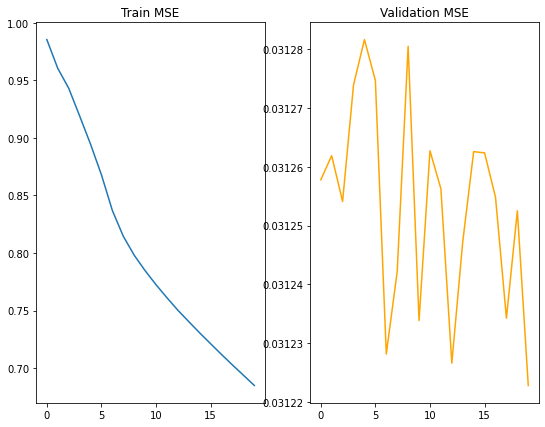

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 7))
ax1.plot(epochs_losses_train)
# ax1.set_yscale("log")
ax1.set_title("Train MSE")
ax2.plot(epochs_losses_val, 'orange')
ax2.set_title("Validation MSE")

In [11]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss
}, "C:\\Users\\nikos\\Desktop\\denoising\\new-model-20-smallLR.pth")


In [12]:
# from time import sleep
# sleep(60*2)
# os.system("shutdown -l")
